# Step 1: Import Required Libraries

#### dataset Link: https://www.kaggle.com/datasets/jyotmakadiya/top-trending-videos-youtube-2021?select=US_videos_data.csv

In [138]:
import pandas as pd
from transformers import BertTokenizer, TFBertModel
import torch
import re
from sklearn.metrics.pairwise import cosine_similarity

# Step 2: Load and Preprocess the Dataset



In [139]:
# Load the CSV file
df_yt = pd.read_csv('/content/US_videos_data.csv')
df_yt = df_yt[['title','channelTitle','likes','dislikes','thumbnail_link','description']]
df_yt.head()

,title,channelTitle,likes,dislikes,thumbnail_link,description
0,Meatpacking: Last Week Tonight with John Olive...,LastWeekTonight,60111,1221,https://i.ytimg.com/vi/IhO1FcjDMV4/default.jpg,The pandemic has thrown into high relief some ...
1,"Best 3D Pen Art Wins $5,000 Challenge! | ZHC C...",ZHC Crafts,50662,690,https://i.ytimg.com/vi/p4Wy84AOzj0/default.jpg,I can't believe we made art using 3d pens and ...
2,100 Days - [Minecraft Superflat],Luke TheNotable,372753,7961,https://i.ytimg.com/vi/4eKXwKDdXYA/default.jpg,This video is intended for audiences 13+ years...
3,Amazing! Luke Bryan Calls 15-Year-Old Casey Bi...,American Idol,14267,129,https://i.ytimg.com/vi/XHR5mt2gBjo/default.jpg,Small but MIGHTY! Casey Bishop completely blow...
4,Game Theory: Did Reddit Just SOLVE FNAF?,The Game Theorists,225780,2872,https://i.ytimg.com/vi/C-icyHEb7W4/default.jpg,Get Yourself Some BRAND NEW Theory Wear! ► htt...


In [140]:
df_yt.shape

(6000, 6)

In [141]:
# Drop duplicate titles
df_yt = df_yt.drop_duplicates(subset=['title'])

In [142]:
df_yt.isnull().sum()

,0
title,0
channelTitle,0
likes,0
dislikes,0
thumbnail_link,0
description,4


In [143]:
df_yt.dropna(inplace=True)

# Cleaning

In [147]:
df_yt['clean_title'] = df_yt['title'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x) if isinstance(x, str) else '')

# Step 3: Load BERT Model and Preprocessor from TensorFlow Hub



In [148]:
# Load the Hugging Face BERT tokenizer and model for TensorFlow
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

# Step 4: Create a BERT Embedding Model


In [149]:

def get_bert_embeddings(text, tokenizer, model):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors='tf', padding=True, truncation=True, max_length=512)

    # Use the Hugging Face TFBertModel to get the embeddings
    outputs = model(inputs)

    # Return the pooled output (embedding for the [CLS] token)
    return outputs.pooler_output.numpy()

# Apply the function to each cleaned title in the DataFrame
df_yt['embeddings'] = df_yt['clean_title'].apply(lambda x: get_bert_embeddings(x, tokenizer, model))


#### #xplanation

Let's go through how embeddings work on text using two simple sentences as examples. We'll use the following sentences:

Sentence 1: "I love cats."

Sentence 2: "I love dogs."

Embeddings are numerical representations of text that capture the semantic meaning of words or sentences.


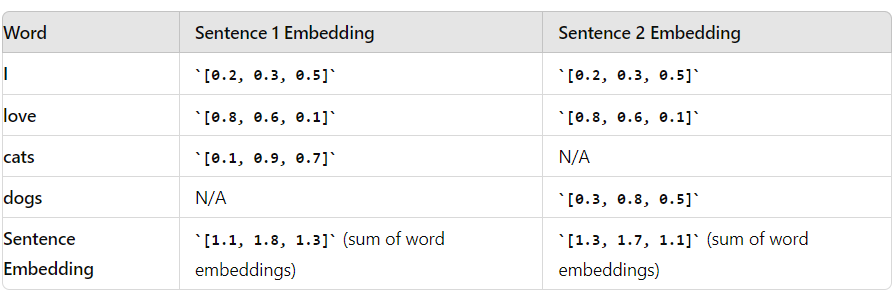


##### Word Embeddings:

Each word in the sentences is converted into a vector (an embedding) using a pre-trained model like Word2Vec, GloVe, or a deep learning model like BERT.


For simplicity, let's say each word is represented in a 3-dimensional space.


#### Sentence Embeddings:

Sentence embeddings can be derived by combining word embeddings. Here, we use a simple summation of the word vectors to form the sentence embedding.

Sentence 1 Embedding: Sum of the embeddings of "I", "love", and "cats".

Sentence 2 Embedding: Sum of the embeddings of "I", "love", and "dogs".

##### Cosine Similarity (Optional):


To compare the similarity between the two sentences, we could calculate the cosine similarity between the sentence embeddings. The closer the cosine similarity to 1, the more similar the sentences are in meaning.

In [150]:
df_yt.head()

,title,channelTitle,likes,dislikes,thumbnail_link,description,clean_title,embeddings
0,Meatpacking: Last Week Tonight with John Olive...,LastWeekTonight,60111,1221,https://i.ytimg.com/vi/IhO1FcjDMV4/default.jpg,The pandemic has thrown into high relief some ...,Meatpacking Last Week Tonight with John Oliver...,"[[-0.838199, -0.49441856, -0.6015339, 0.635408..."
1,"Best 3D Pen Art Wins $5,000 Challenge! | ZHC C...",ZHC Crafts,50662,690,https://i.ytimg.com/vi/p4Wy84AOzj0/default.jpg,I can't believe we made art using 3d pens and ...,Best 3D Pen Art Wins 5000 Challenge ZHC Crafts,"[[-0.83370966, -0.49846026, -0.80845195, 0.689..."
2,100 Days - [Minecraft Superflat],Luke TheNotable,372753,7961,https://i.ytimg.com/vi/4eKXwKDdXYA/default.jpg,This video is intended for audiences 13+ years...,100 Days Minecraft Superflat,"[[-0.82278967, -0.3817129, -0.63249594, 0.7180..."
3,Amazing! Luke Bryan Calls 15-Year-Old Casey Bi...,American Idol,14267,129,https://i.ytimg.com/vi/XHR5mt2gBjo/default.jpg,Small but MIGHTY! Casey Bishop completely blow...,Amazing Luke Bryan Calls 15YearOld Casey Bisho...,"[[-0.85991347, -0.3150027, 0.1849849, 0.530873..."
4,Game Theory: Did Reddit Just SOLVE FNAF?,The Game Theorists,225780,2872,https://i.ytimg.com/vi/C-icyHEb7W4/default.jpg,Get Yourself Some BRAND NEW Theory Wear! ► htt...,Game Theory Did Reddit Just SOLVE FNAF,"[[-0.8647456, -0.41429695, -0.582271, 0.714787..."


In [151]:
# save fianal df
df_yt.to_csv('final_df.csv', index=False)

# Step 5: Calculate Similarity Scores and Get Recommendations:

 # Recommendation System For YT Videos

In [155]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def compute_cosine_similarity(embedding, embeddings):
    """
    Compute cosine similarity between a single embedding and all other embeddings.

    Args:
    - embedding (np.ndarray): The embedding vector for the input title.
    - embeddings (list of np.ndarray): List of all embedding vectors in the dataset.

    Returns:
    - similarities (np.ndarray): Array of cosine similarities.
    """
    similarities = cosine_similarity(embedding.reshape(1, -1), np.vstack(embeddings)).flatten()
    return similarities

def recommend_videos(title, df, tokenizer, model, top_n=5):
    """
    Recommend top N similar videos based on the embeddings of the cleaned titles.

    Args:
    - title (str): The title of the video for which we want to find similar videos.
    - df (pd.DataFrame): DataFrame containing video data and embeddings.
    - tokenizer (BertTokenizer): Hugging Face tokenizer.
    - model (TFBertModel): Hugging Face BERT model.
    - top_n (int): Number of similar videos to recommend.

    Returns:
    - recommendations (pd.DataFrame): DataFrame of recommended videos.
    """
    # Preprocess and get the embedding for the input title
    cleaned_title = re.sub('[^A-Za-z0-9]+', ' ', title.lower())
    embedding = get_bert_embeddings(cleaned_title, tokenizer, model)

    # Compute similarities between the input embedding and all other embeddings
    similarities = compute_cosine_similarity(embedding, df['embeddings'].tolist())

    # Add the similarity scores to the DataFrame
    df['similarity'] = similarities

    # Sort the DataFrame based on similarity scores in descending order
    df_sorted = df.sort_values(by='similarity', ascending=False)

    # Return the top N recommendations (excluding the input title itself if it's present)
    recommendations = df_sorted[df_sorted['title'] != title].head(top_n)

    return recommendations[['title', 'channelTitle','likes','dislikes','thumbnail_link', 'similarity']]

In [156]:
from IPython.display import display, HTML
import pandas as pd

def display_recommendations(recommendations):
    # Generate HTML for displaying thumbnails and metadata
    html = '<div style="display: flex; flex-wrap: wrap; justify-content: space-around;">'

    # Iterate over recommendations in pairs (2 thumbnails per row)
    for i in range(0, len(recommendations), 2):
        row_html = '<div style="display: flex; justify-content: space-around; width: 100%;">'

        # Iterate through each item in the pair (2 thumbnails per row)
        for j in range(2):
            if i + j < len(recommendations):
                # Fetch data for each recommendation
                recommendation = recommendations.iloc[i + j]
                title = recommendation['title']
                thumbnail = recommendation['thumbnail_link']
                likes = recommendation['likes']
                dislikes = recommendation['dislikes']
                similarity = recommendation['similarity']
                channelTitle = recommendation['channelTitle']

                # Generate HTML for each video thumbnail and details
                row_html += f'''
                <div style="width: 20%; margin: 2px; text-align: center; border: 1px solid #ddd; padding: 2px; border-radius: 10px;">
                    <img src="{thumbnail}" alt="{title}" style="width: 100%; border-radius: 5px;">
                    <h4>{title}</h4>
                    <p>Channel: {channelTitle}</p>
                    <p>Likes: {likes} | Dislikes: {dislikes}</p>
                    <p>Similarity: {similarity:.2f}</p>
                </div>
                '''
        row_html += '</div>'
        html += row_html

    html += '</div>'
    display(HTML(html))


In [159]:
# Example usage
title_to_recommend = input("Your Input Video Title Here : ")
top_recommendations = recommend_videos(title_to_recommend, df_yt, tokenizer, model, top_n=10)

# Display the recommendations
display_recommendations(top_recommendations)

Jack Harlow: Tiny Desk (Home) Concert : Jack Harlow: Tiny Desk (Home) Concert


In [160]:
# Example usage
title_to_recommend = input("Your Input Video Title Here")
top_recommendations = recommend_videos(title_to_recommend, df_yt, tokenizer, model, top_n=10)

# Display the recommendations
display_recommendations(top_recommendations)


Your Input Video Title HereCell in a Hell | HFIL
